In [1]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
 from torchdiffeq import odeint_adjoint as odeint

In [3]:
true_y0 = torch.tensor([[0., 0.001]])    # 0.001 to prevent division by zero
t = torch.linspace(0., 25., 1000)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

- We have a differential equation and an initial value (i.e. initial value problem), which is:
$$ (\frac{dy_1}{dt}, \frac{dy_2}{dt}) = (0.2, \frac{1}{2y_2}) \\ (y_1, y_2)|_{t=0} = (0, 0) $$

- where the solution is,
$$ y_1(t) = 0.2t \\ y_2(t) = \sqrt{t} $$

In [4]:
class myFunc(nn.Module):
    def forward(self, t, y):
        return torch.tensor([[0.2 , 1/(2*y[:,1])]])

In [5]:
with torch.no_grad():
    true_y = odeint(myFunc(), true_y0, t, method='dopri5')

- True solution using traditional numerical integrator
- $y_1$=5, $y_2$=5 at t=25

In [6]:
true_y[-5:]

tensor([[[4.9800, 4.9900]],

        [[4.9850, 4.9925]],

        [[4.9900, 4.9950]],

        [[4.9950, 4.9975]],

        [[5.0000, 5.0000]]])

In [7]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [8]:
data_size = 1000
batch_time = 10
batch_size = 20

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), size=batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [9]:
batch_y0, batch_t, batch_y = get_batch()

In [10]:
batch_y0.shape

torch.Size([20, 1, 2])

In [11]:
batch_t

tensor([0.0000, 0.0250, 0.0501, 0.0751, 0.1001, 0.1251, 0.1502, 0.1752, 0.2002,
        0.2252])

In [12]:
batch_y.shape

torch.Size([10, 20, 1, 2])

In [13]:
import matplotlib.pyplot as plt

In [14]:
def visualize(true_y, pred_y, odefunc, itr):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-', label='True 0')
    ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], 'g--', label='Pred 0')
    ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 1], 'b-', label= 'True 1')    
    ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 1], 'b--', label= 'Pred 1')
    
    ax_traj.set_xlim(t.min(), t.max())
    ax_traj.set_ylim(-2, 7)
    ax_traj.legend()

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-', label='True')
    ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--', label='Pred')
    ax_phase.set_xlim(-2, 7)
    ax_phase.set_ylim(-2, 7)
    ax_phase.legend()
    
    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:7:21j, -2:7:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 7)
    ax_vecfield.set_ylim(-2, 7)

    fig.tight_layout()
    plt.draw()
    plt.pause(0.001)

Iter 0000 | Total Loss 2.440025


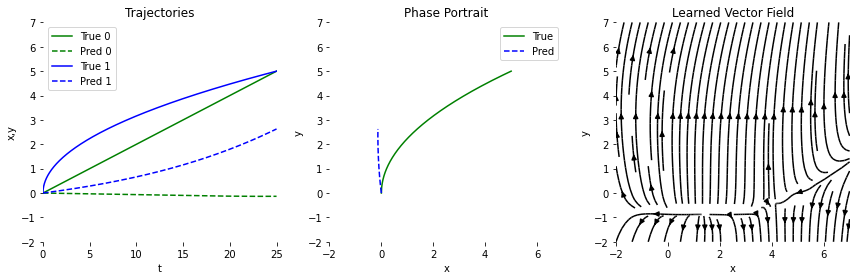

Iter 0200 | Total Loss 0.634434


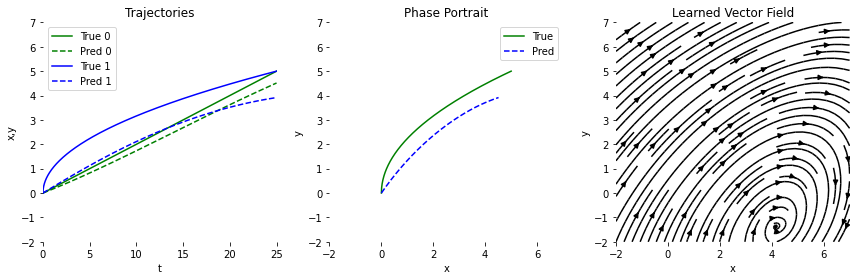

Iter 0400 | Total Loss 0.377395


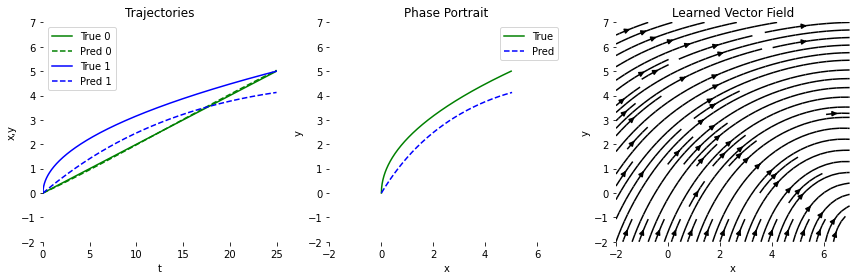

Iter 0600 | Total Loss 0.153674


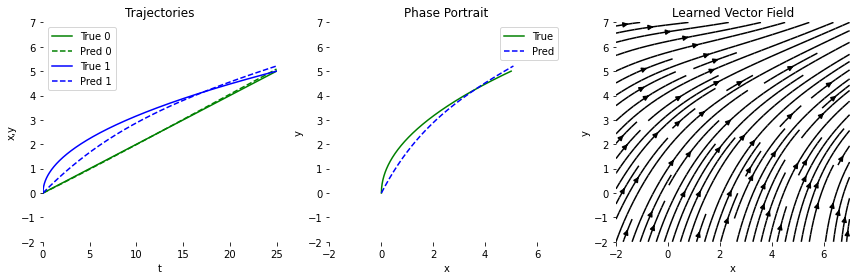

Iter 0800 | Total Loss 0.173029


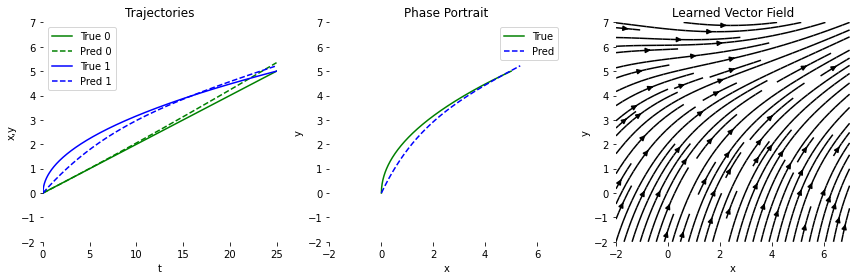

Iter 1000 | Total Loss 0.146262


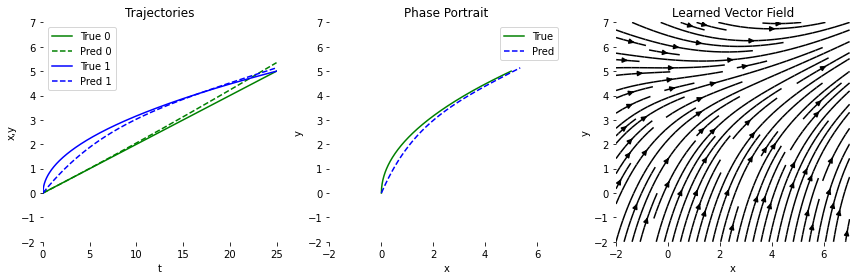

Iter 1200 | Total Loss 0.130376


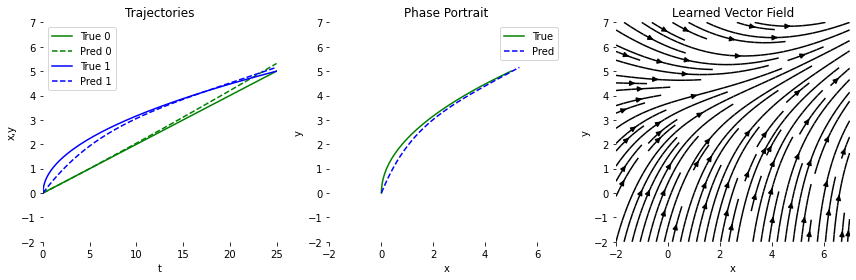

Iter 1400 | Total Loss 0.174775


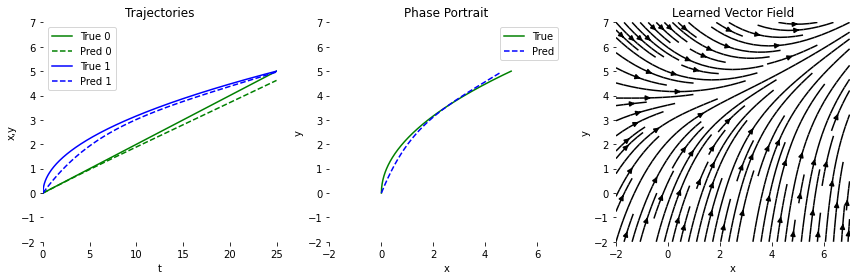

In [15]:
ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for itr in range(1500):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 200 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1